In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ReLU, Input, LeakyReLU, Conv2D, Activation, MaxPool2D, Flatten, Dense, Reshape, Conv2DTranspose, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from pathlib import Path
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import cv2
import numpy as np
from glob import glob 
from keras import backend as K
from contextlib import redirect_stdout
from keras.models import Model


PATH = 'G:/Deletar/pictures_conv'

PRECISION = tf.float32
HEIGHT = 128
WIDTH = 128
FILTERS = 128
KERNEL_SIZE = 3
STRIDES = 1
BATCH = 1
OUTPUT_CHANNELS = 3


train_bw = glob("G:\\Deletar\\pictures_conv\\train_new\\bw\\*.jpg")
train_color = glob("G:\\Deletar\\pictures_conv\\train_new\\color\\*.jpg")
test_bw = glob("G:\\Deletar\\pictures_conv\\test_new\\bw\\*.jpg")
test_color = glob("G:\\Deletar\\pictures_conv\\test_new\\color\\*.jpg")

In [18]:
# apply black and white colors to image
def apply_bw(filename):
    img = plt.imread(filename)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Input IMG is RGB
    img = cv2.merge([img,img,img])
    return img

def resize_image2(data):
    resized_img = tf.image.resize(
    images=K,
    size=[HEIGHT, WIDTH],
    method=tf.image.ResizeMethod.BILINEAR,
    preserve_aspect_ratio=False,
    antialias=True,
    )    
    return resized_img

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, PRECISION)
    img = tf.image.resize(img, size=(HEIGHT, WIDTH))
    return img

# read img and transform into tensor image
def read_img(filename):
    img = plt.imread(filename)
    if len(img.shape) == 2:
        img = cv2.merge([img,img,img])
    img = tf.convert_to_tensor(img/255., dtype=PRECISION)
    return img

def get_all_info(folder):
    imgs = []
    for file in os.listdir(folder):
        img_tensor = read_img(folder + "\\" + file) 
    return imgs

""" z = get_all_info("G:\\Deletar\\pictures_conv\\train_new\\bw") """

files_ds = tf.data.Dataset.from_tensor_slices((train_bw, train_color))
files_ds = files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(BATCH)
example = list(files_ds.as_numpy_iterator())

In [19]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, padding='same', strides=2, name='conv2d_01', kernel_initializer=initializer, use_bias=False),)                           
    """ result.add(      
     Conv2D(tf.keras.layers.Conv2D(filters, kernel_size = size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))) """
    if apply_batchnorm:
      result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = Sequential()
  result.add(
    Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
  result.add(BatchNormalization())
  if apply_dropout:
      result.add(Dropout(0.5))
  result.add(ReLU())
  return result


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, x_test):
        self.model = model

    def on_epoch_end(self, epoch, logs={}):
      if epoch % 5 == 0: 
        z = self.model.predict(example[0][0])
        plt.imshow(z[0])
        plt.show()
        

Epoch 1/5
1002/1002 [==============================] - 29s 29ms/step - loss: 0.0437 - accuracy: 0.4322


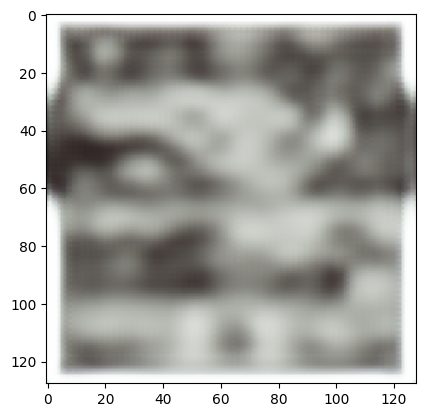

Epoch 2/5
1002/1002 [==============================] - 27s 27ms/step - loss: 0.0285 - accuracy: 0.4471
Epoch 3/5
1002/1002 [==============================] - 27s 27ms/step - loss: 0.0248 - accuracy: 0.4480
Epoch 4/5
1002/1002 [==============================] - 27s 27ms/step - loss: 0.0228 - accuracy: 0.4481
Epoch 5/5
1002/1002 [==============================] - 28s 28ms/step - loss: 0.0216 - accuracy: 0.4489
AxesImage(size=(128, 128))


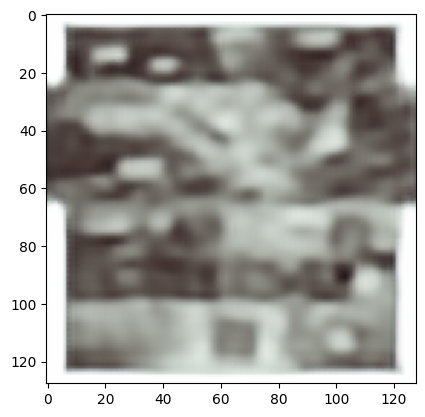

In [20]:
""" model = Sequential([
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_01'),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_01'),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_02'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_02'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_03'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPool2D((2, 2),  padding='same', name='max_pool_04'),
    Conv2D(FILTERS/4, (3, 3),  padding='same', name='conv2d_04'),
    Dropout(0.5),
    Activation('relu', name='relu_04'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS/2, (3, 3),  padding='same', name='conv2d_05'),
    Dropout(0.5),
    Activation('relu', name='relu_05'),
    UpSampling2D((2, 2)),
    Conv2D(FILTERS, (3, 3),  padding='same', name='conv2d_06'),
    Activation('relu', name='relu_06'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same'),
    Activation('tanh'),    
]) """
initializer = tf.random_normal_initializer(0., 0.02)
# model.add(Input(shape=[HEIGHT, WIDTH, 3]))

""" model.add(downsample(128,4, apply_batchnorm=False))
model.add(upsample(128,4, apply_dropout=True)) """

""" model = Sequential()
model.add(downsample(64,9, apply_batchnorm=False))
model.add(downsample(128,4))
model.add(upsample(128,4, apply_dropout=True))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


model = Sequential()
model.add(Input(shape=(128, 128, 3,)))
#Encoder
model.add(Conv2D(64, (9,9), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
#Decoder

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh'))

""" model.add(Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer))
model.add(Activation('tanh')) """


""" 
model.add(UpSampling2D((2, 2))) """

""" encoder_output = (encoder_input)



decoder_output = (encoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output)
decoder_output = (decoder_output) """


model.compile(
    #""" loss=tf.keras.losses.BinaryCrossentropy(), """
    # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    loss= tf.keras.losses.MeanSquaredError(),
    optimizer="Adam",
    metrics=["accuracy"]
)



model.fit(files_ds,epochs=5, callbacks=[CustomCallback(model, files_ds)])




z = model.predict(example[0][0])

print(plt.imshow(z[0]))



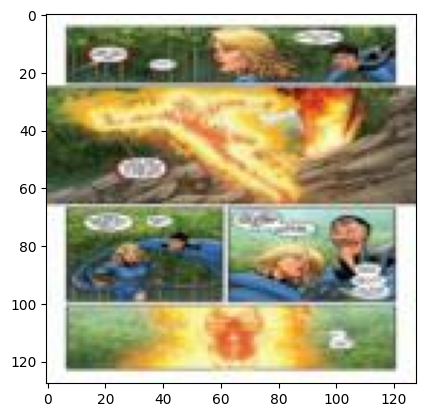

In [21]:
plt.imshow(example[0][1][0])